# Processed Github BigQuery data

In [1]:
from toolz import partial
import os
import glob
import pandas as pd
from operator import itemgetter

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')

from sklearn import metrics, decomposition, naive_bayes, linear_model

from sklearn import feature_extraction
from sklearn import model_selection

from github_search import exploration

In [2]:
DATA_DIR = os.path.join('..', 'data')

In [3]:
github_repos_df = pd.read_csv(os.path.join(DATA_DIR, 'github_repos_lm.csv'))

In [4]:
github_repos_df.columns

Index(['Unnamed: 0', 'repo_name', 'languages', 'content', 'text'], dtype='object')

In [5]:
github_repos_df.shape

(177103, 5)

In [6]:
content_length = github_repos_df['content'][~github_repos_df['content'].isna()].apply(len)

In [9]:
github_repos_df['languages'].apply(len).describe()

count    177103.000000
mean         33.971943
std          40.420220
min           5.000000
25%          10.000000
50%          19.000000
75%          41.000000
max        2238.000000
Name: languages, dtype: float64

In [10]:
(github_repos_df['repo_name'].value_counts() > 1).sum()

2022

In [11]:
def parse_string_list(string_list):
    return string_list.replace("'", '')[1:-1].split(', ')

In [12]:
languages = github_repos_df['languages'].apply(parse_string_list)

In [13]:
lang_counts = exploration.get_languages_counter(languages)

In [14]:
top_langs = exploration.get_top_langs(languages, 25)

In [15]:
top_langs

['Python',
 'Shell',
 'Java',
 'C++',
 'C',
 'Makefile',
 'Objective-C',
 'Perl',
 'Batchfile',
 'Ruby',
 'CMake',
 'Assembly',
 'PHP',
 'Scala',
 'R',
 'XSLT',
 'Groff',
 'Awk',
 'C#',
 'TeX',
 'Groovy',
 'Matlab',
 'Objective-C++',
 'ASP',
 'QMake']

## Topic labeling with Snorkel

In [16]:
from snorkel import labeling

ABSTAIN = -1
NON_DATA_SCIENCE = 0
DATA_SCIENCE = 1


def keyword_lookup(x, keywords, label):
    if any(word in x.content.lower() for word in keywords):
        return label
    return ABSTAIN


def make_keyword_lf(keyword, label=DATA_SCIENCE):
    return labeling.LabelingFunction(
        name=f"keyword_{keyword}",
        f=keyword_lookup,
        resources=dict(keywords=[keyword], label=label),
    )

In [48]:
ds_keywords = ['machine learning', 'data science', 'artificial intelligence',
           'classification', 'regression', 'clustering', 'dimensionality reduction',
            'supervised', 'tensor', 'scikit-learn', 'sklearn', 'pytorch'
           ]

non_ds_keywords = [
    'java', 'scraping', 'php', 'ruby', 'database', 'elastic',
    'frontend', 'android', 'framework', 'script', 'devops', 'c++']

In [49]:
ds_lfs = [make_keyword_lf(word) for word in ds_keywords]
non_ds_lfs = [make_keyword_lf(word, NON_DATA_SCIENCE) for word in non_ds_keywords]

In [50]:
lfs = ds_lfs+non_ds_lfs
applier = labeling.PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=github_repos_df)

100%|██████████| 177103/177103 [00:45<00:00, 3894.29it/s]


In [51]:
lfanalysis_df = labeling.LFAnalysis(L=L_train, lfs=lfs).lf_summary()
lfanalysis_df['Conflicts/Coverage'] = lfanalysis_df['Conflicts'] / lfanalysis_df['Coverage']
lfanalysis_df

,j,Polarity,Coverage,Overlaps,Conflicts,Conflicts/Coverage
keyword_machine learning,0,[1],0.007764,0.004709,0.003252,0.418909
keyword_data science,1,[1],0.001733,0.000982,0.000678,0.390879
keyword_artificial intelligence,2,[1],0.001395,0.000768,0.000542,0.388664
keyword_classification,3,[1],0.004862,0.003202,0.001908,0.392567
keyword_regression,4,[1],0.004444,0.002902,0.001875,0.421855
keyword_clustering,5,[1],0.003461,0.001903,0.001474,0.425775
keyword_dimensionality reduction,6,[1],0.000198,0.000141,0.000068,0.342857
keyword_supervised,7,[1],0.001615,0.001056,0.000553,0.342657
keyword_tensorflow,8,[1],0.003354,0.001931,0.001395,0.415825
keyword_scikit-learn,9,[],0.000000,0.000000,0.000000,NaN


In [68]:
y = L_train.max(axis=1) == 1

In [71]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(github_repos_df['content'], y, stratify=y)

In [72]:
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000)

In [73]:
%%time
X_train_bow = vectorizer.fit_transform(X_train)

CPU times: user 9.51 s, sys: 179 ms, total: 9.69 s
Wall time: 9.69 s


In [74]:
X_test_bow = vectorizer.transform(X_test)

In [75]:
X_test_bow

<44276x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 2920566 stored elements in Compressed Sparse Row format>

# Classifying programming languages

## Naive Bayes

In [76]:
multi_nb = naive_bayes.MultinomialNB(alpha=0.1)

In [77]:
%%time

multi_nb.fit(X_train_bow, y_train)

CPU times: user 37.7 ms, sys: 3.8 ms, total: 41.5 ms
Wall time: 41.1 ms


MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [78]:
multi_nb.score(X_train_bow, y_train)

0.983632845731666

In [79]:
multi_nb.score(X_test_bow, y_test)

0.9823154756527238

In [88]:
metrics.f1_score(y_test, multi_nb.predict(X_test_bow))

0.5523156089193826

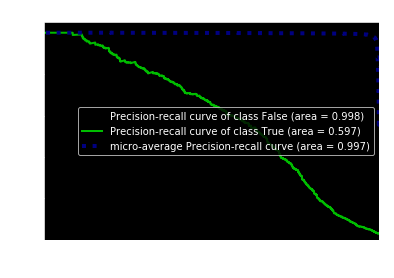

In [108]:
skplt.metrics.plot_precision_recall(y_test, multi_nb.predict_proba(X_test_bow));

In [80]:
print(metrics.classification_report())

              precision    recall  f1-score   support

       False       0.99      1.00      0.99     43223
        True       0.69      0.46      0.55      1053

   micro avg       0.98      0.98      0.98     44276
   macro avg       0.84      0.73      0.77     44276
weighted avg       0.98      0.98      0.98     44276



## SGD linear regression with Lasso penalty

In [81]:
lasso = linear_model.SGDClassifier(loss='log', penalty='l1', alpha=0.0001, random_state=0)

In [82]:
%%time
lasso.fit(X_train_bow, y_train)

/etc/miniconda/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


CPU times: user 390 ms, sys: 0 ns, total: 390 ms
Wall time: 389 ms


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=0, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [83]:
lasso.score(X_train_bow, y_train)

0.9823680426419328

In [84]:
lasso.score(X_test_bow, y_test)

0.9824509892492547

In [94]:
import scikitplot as skplt

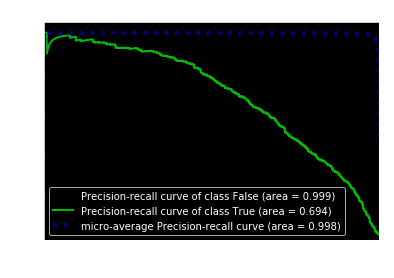

In [103]:
skplt.metrics.plot_precision_recall(y_test, lasso.predict_proba(X_test_bow));

In [93]:
metrics.roc_auc_score(y_test, lasso.predict_proba(X_test_bow)[:,1])

0.9719171335633251

In [85]:
print(metrics.classification_report(y_test, lasso.predict(X_test_bow)))

              precision    recall  f1-score   support

       False       0.98      1.00      0.99     43223
        True       0.91      0.29      0.44      1053

   micro avg       0.98      0.98      0.98     44276
   macro avg       0.95      0.64      0.72     44276
weighted avg       0.98      0.98      0.98     44276



# Topic modeling

In [110]:
nmf = decomposition.NMF(n_components=50, l1_ratio=0.5, alpha=0.001)

In [111]:
%%time
nmf.fit(X_train_bow)

CPU times: user 3min 43s, sys: 48.1 s, total: 4min 32s
Wall time: 3min 6s


NMF(alpha=0.001, beta_loss='frobenius', init=None, l1_ratio=0.5, max_iter=200,
  n_components=50, random_state=None, shuffle=False, solver='cd',
  tol=0.0001, verbose=0)

In [112]:
from mlutil import topic_modeling

topic_modeling.top_topic_words(nmf, list(vectorizer.vocabulary_.keys()), 10)

W0829 23:57:22.170205 140325512234816 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


,0,1,2,3,4,5,6,7,8,9
topic_0,bp,children,visualizing,over,regional,restaurants,tile,agreements,project_name,xhtml
topic_1,glyphicons,mistake,shinken,primes,mixer,assertj,victor,guava,achieves,crcxxnumber
topic_2,datastore,equipped,msi,manipulation,lives,linguistic,sword,shopping,parallax,trinitycore
topic_3,dpdk,glyphicons,receiver,kite,workspace,fit,mega,java_home,often,internals
topic_4,kite,lollipop,advances,file,subdirectory,fig,exploration,index,hpi,hxxnumberpy
topic_5,phonegap,目录,leveraging,adobe,ann,beginning,workspace,general,dispatch,statsd
topic_6,starts,taylor,versus,voting,flush,fps,shortcut,white_check_mark,combat,pipenv
topic_7,engineers,recommender,standing,loosely,translate,freenode,adheres,crcxxnumber,pb,map
topic_8,temporal,plant,internals,recommender,agreements,appxxnumber,shiny,xorg,former,victor
topic_9,rhythmbox,internals,currencies,planner,discussion,storm,encoded,former,triples,hackathon


In [120]:
X_train_nmf = nmf.transform(X_train_bow)
X_test_nmf = nmf.transform(X_test_bow)

## Random Forest

In [121]:
from sklearn import ensemble

rf_clf = ensemble.RandomForestClassifier(n_estimators=100, max_depth=15, random_state=0, n_jobs=-1)

In [122]:
%%time
rf_clf.fit(X_train_nmf, y_train)

CPU times: user 1min 26s, sys: 194 ms, total: 1min 27s
Wall time: 8.56 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [123]:
rf_clf.score(X_train_nmf, y_train)

0.9899041610515934

In [126]:
rf_clf.score(X_test_nmf, y_test)

0.982179962056193

In [129]:
rf_clf.predict_proba(X_test_nmf).shape

(44276, 2)

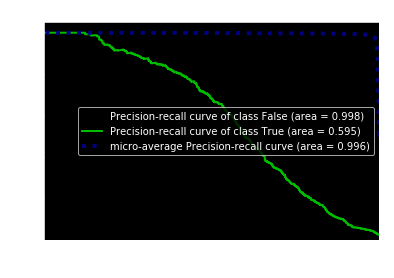

In [130]:
skplt.metrics.plot_precision_recall(y_test, rf_clf.predict_proba(X_test_nmf));